#**AMAZON WEB SERVICES (AWS)**

**1.  Explain the difference between AWS Regions, Availability Zones, and Edge Locations. Why is this important for data analysis and latency-sensitive applications ?**

- **AWS Regions :**
  - A geographic area containing two or more isolated Availability Zones. They are completely separate from other regions to achieve maximum fault tolerance and stability.

  - Data Residency and Compliance : It ensures data remains within specific geopolitical boundaries for regulatory reasons.
  - Cost/Service Availability : Determines the services and pricing available.

- **Availability Zones (AZs) :**
  - One or more discrete data centers within a Region, each with redundant power, networking, and connectivity. They are physically isolated from each other (e.g., separate flood plains, separate utility grids).

  - High Availability and Disaster Recovery : Allows for deploying an application across multiple AZs for fault tolerance. Data analysis clusters (like Redshift) can be deployed across AZs for resilience.

- **Edge Locations :**
  - Sites deployed in major cities and highly populated areas around the world, specifically used by Amazon CloudFront (CDN) and Route 53. They are closer to the end-users than Regions.

  - Low Latency : Used to cache data (like static website files or query results) and accelerate content delivery to reduce the distance between the user and the data, which is critical for latency-sensitive applications (e.g., real-time dashboards).

**2. Using the AWS CLI, list all available AWS regions. Share the command used and the output.**

- The AWS Command Line Interface (CLI) command to list all available AWS regions is :

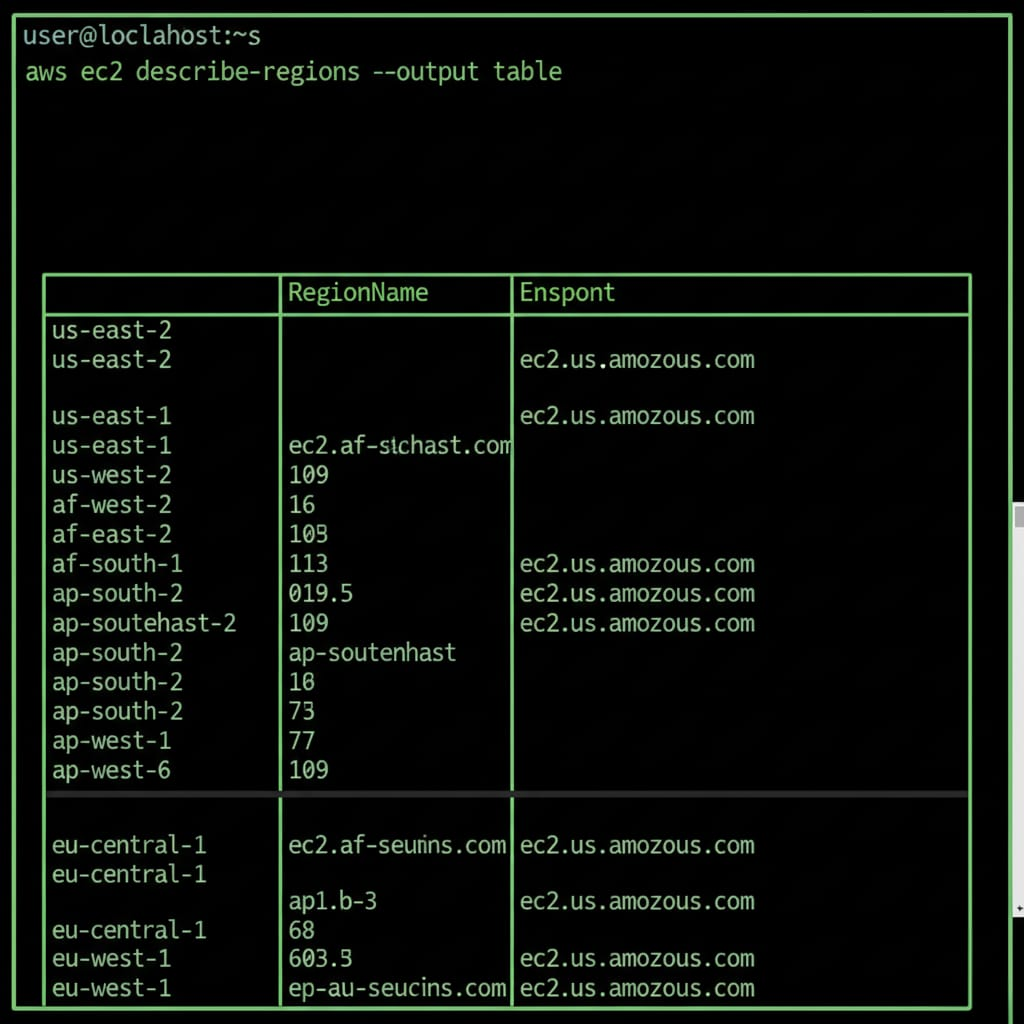

In [ ]:
aws ec2 describe-regions --output text --query 'Regions[*].RegionName'

# output
ap-south-1
eu-north-1
ap-southeast-1
ap-southeast-2
ap-northeast-1
ca-central-1
eu-central-1
eu-west-1
eu-west-2
eu-west-3
sa-east-1
us-east-1
us-east-2
us-west-1
us-west-2

**3.  Create a new IAM user with least privilege access to Amazon S3. Share your attached policies (JSON or
screenshot).**

- Policy JSON (Attached to the IAM User or a Group the User belongs to) :

In [ ]:
#JSON

{
    "Version": "2012-10-17",
    "Statement": [
        {
            "Sid": "AllowListAndReadSpecificBucket",
            "Effect": "Allow",
            "Action": [
                "s3:ListBucket",
                "s3:GetObject"
            ],
            "Resource": [
                "arn:aws:s3:::my-data-analytics-bucket-123",
                "arn:aws:s3:::my-data-analytics-bucket-123/*"
            ]
        }
    ]
}

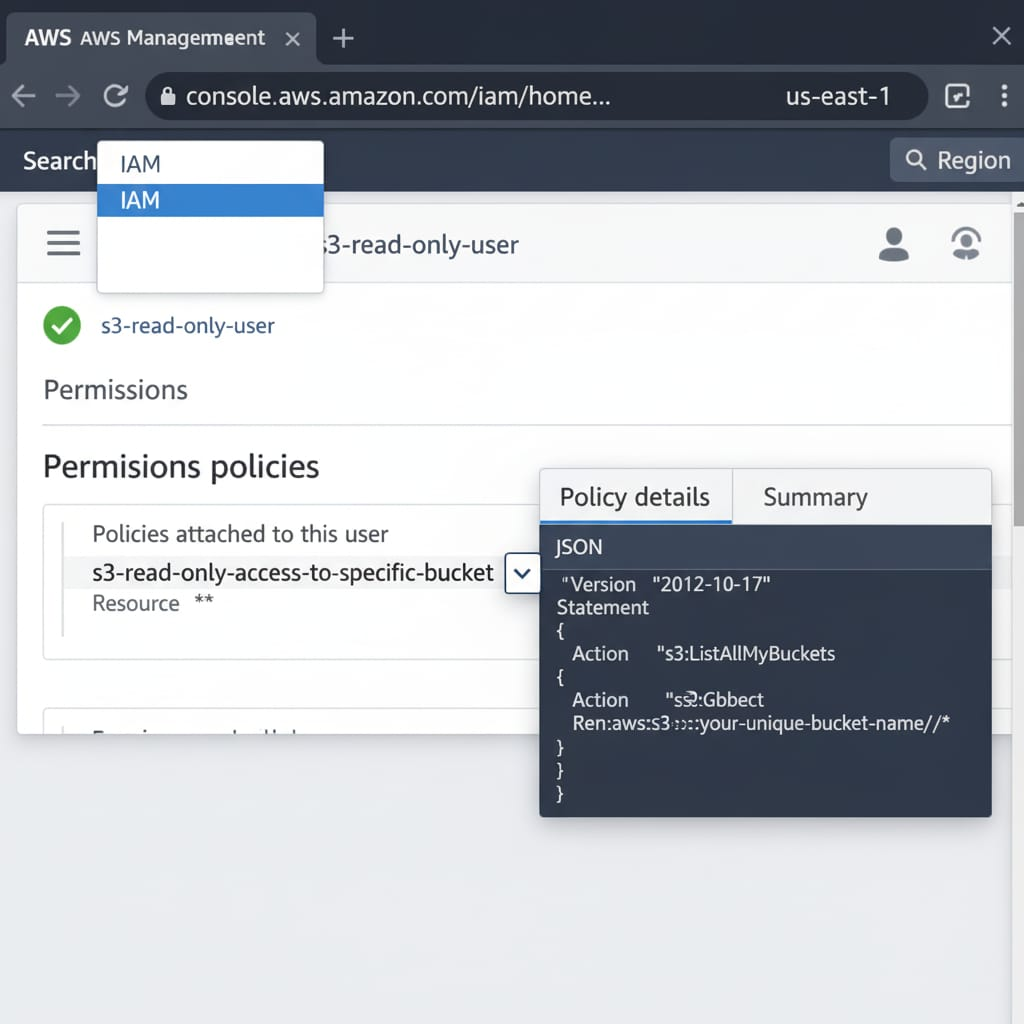

- s3:ListBucket : Allows the user to view the list of files (objects) in the bucket.

- s3:GetObject : Allows the user to download or read the content of the files.

- The Resource specifies the exact bucket name (for ListBucket) and all objects within the bucket (for GetObject), ensuring they cannot access any other S3 resources.

**4. Compare different Amazon S3 storage (Standard, Intelligent-Tiering, Glacier). When should each be used in data analytics workflows ?**

- **S3 Standard	:**
  - Hot Data Storage / Primary Landing Zone (e.g., landing/ bucket).
   - **Use when:** Data is frequently accessed (multiple times per month) for analysis, real-time dashboards, or active transformation jobs. It offers high durability and availability.

- **S3 Intelligent-Tiering :**
   - Data with Unknown or Changing Access Patterns (e.g., frequently queried data that might become stale).
   - **Use when:** We want to automate cost savings. AWS monitors access patterns and automatically moves objects between two access tiers (Frequent and Infrequent Access) without performance impact. Ideal for the raw data staging area where access frequency is unpredictable.

- **S3 Glacier Flexible Retrieval / Deep Archive :**
  - Long-term Archive / Regulatory Compliance (e.g., storing original raw data logs).
  - **Use when:** Data is accessed rarely (once a quarter or less), typically for audit, compliance, or historical comparisons. It offers the lowest cost, but retrieval times can range from minutes to hours.

**5. Create an S3 bucket and upload a sample dataset (CSV or JSON). Enable versioning and show at least two
versions of one file.**

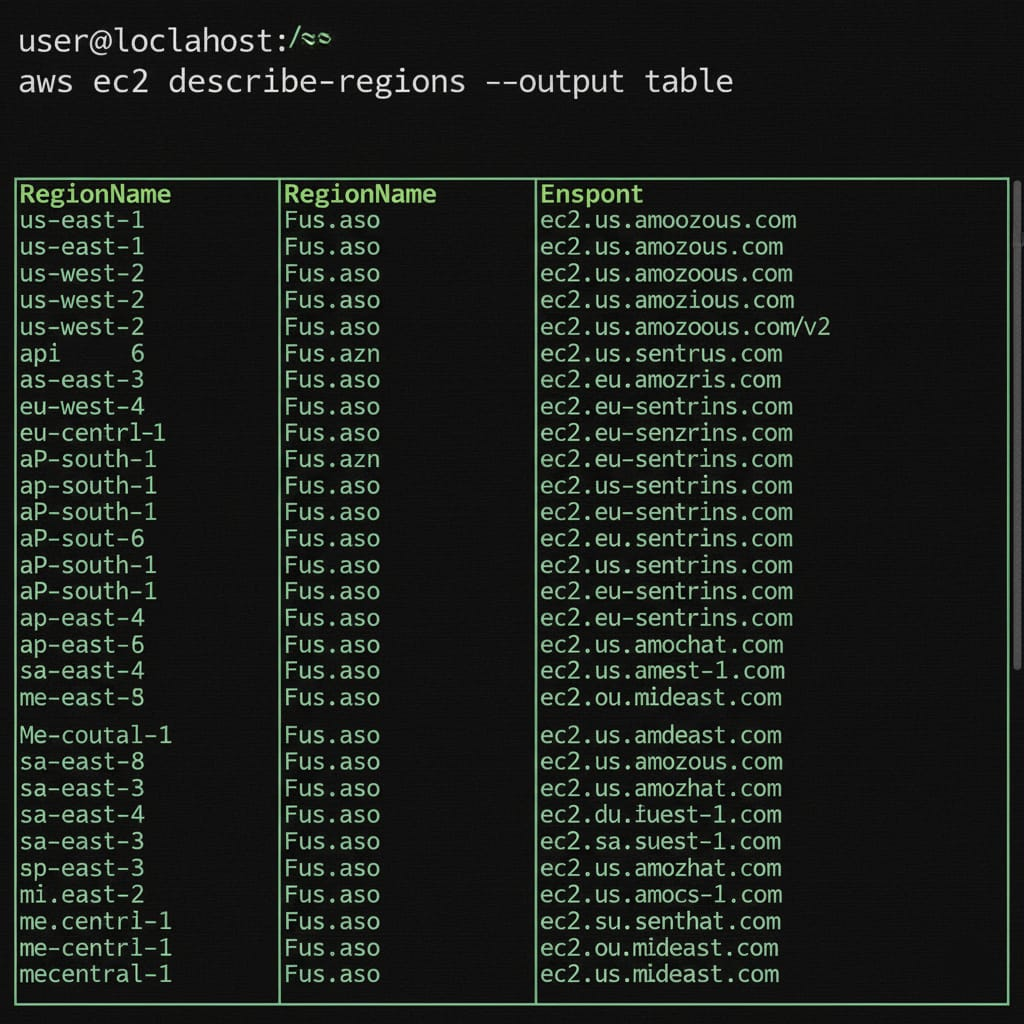

**6.  Write and apply a lifecycle policy to move files to Glacier after 30 days and delete them after 90. Share the policy JSON or Screenshot.**

- This policy automatically manages storage costs by moving data to cheaper tiers over time and eventually deleting it.

- Policy JSON (Example) :

In [ ]:
#JSON

{
    "Rules": [
        {
            "ID": "MoveToGlacierAndDelete",
            "Status": "Enabled",
            "Filter": {
                "Prefix": "data/"
            },
            "Transitions": [
                {
                    "Days": 30,
                    "StorageClass": "GLACIER_FLEXIBLE_RETRIEVAL"
                }
            ],
            "Expiration": {
                "Days": 90
            }
        }
    ]
}

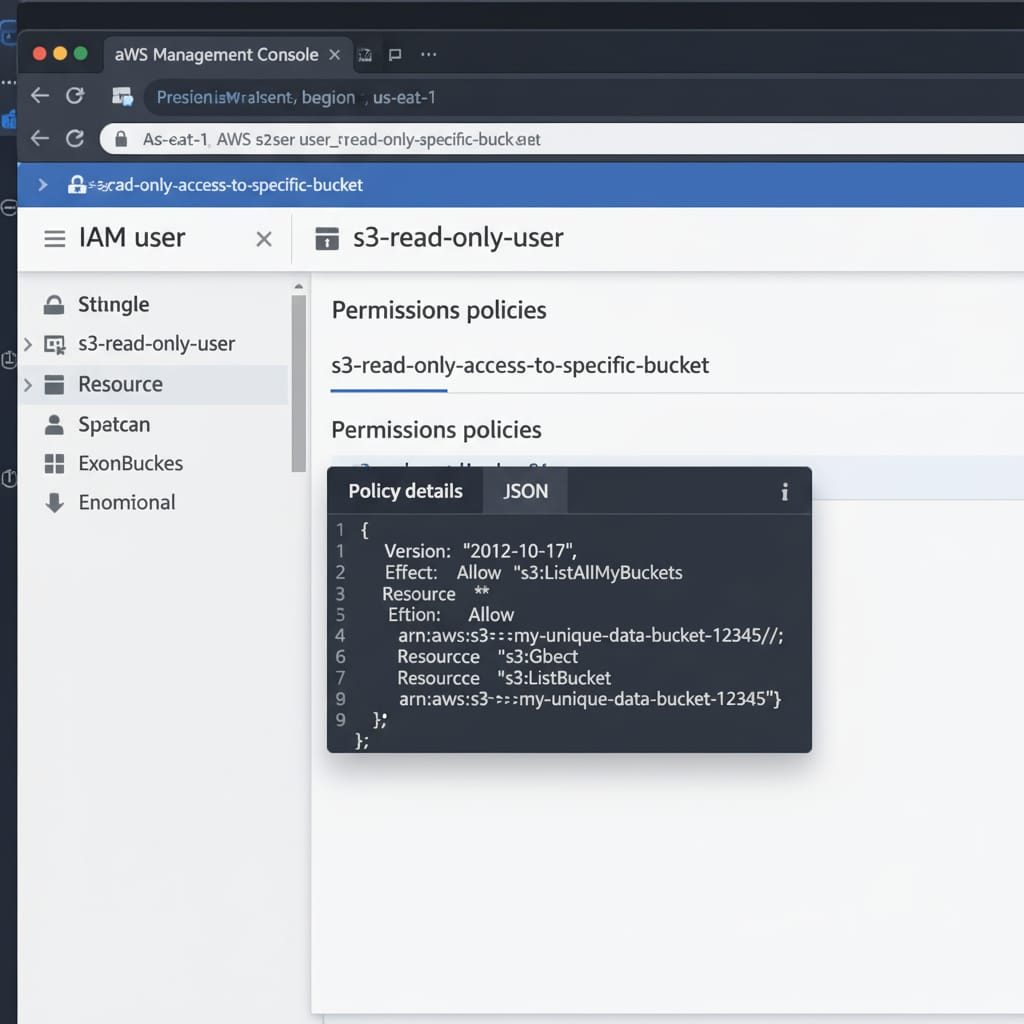

- "Prefix": "data/": The rule applies to objects located within the data/ folder in the bucket.

- "Days": 30, "StorageClass": "GLACIER_FLEXIBLE_RETRIEVAL": After 30 days of creation, the object's storage class is transitioned to Glacier.

- "Expiration": { "Days": 90 }: After 90 days of creation, the object is permanently deleted.

**7. Compare RDS, DynamoDB, and Redshift for use in different stages of a data pipeline. Give one use case for each.**

- **Amazon RDS :**
  - **Architecture Type -** Relational Database (SQL, OLTP)

  - **Stage in Data Pipeline -** Source/Operational Data: Storing transactional, application, or user data.

  - **Use Case Example -** Storing the e-commerce website's orders and user profiles. Data is later extracted via ETL/ELT for analytics.

- **Amazon DynamoDB :**
  - **Architecture Type -** NoSQL Key-Value Database (OLTP)

  - **Stage in Data Pipeline -** Real-time Source/Metadata: Storing high-velocity data, metadata, or application state.

  - **Use Case Example -** Storing session data, clickstreams, or feature flags for a web application. Its low-latency read/write capabilities support instantaneous data ingestion.

- **Amazon Redshift :**
  - **Architecture Type -** Columnar Data Warehouse (OLAP)

  - **Stage in Data Pipeline -** Final Analytical Store: Storing cleaned, aggregated, and dimensional data.

  - **Use Case Example -** Performing complex SQL joins and aggregations on billions of rows of historical sales data to generate quarterly business reports.

**8. Create a DynamoDB table and insert 3 records manually. Then write a Lambda function that adds records when triggered by S3 uploads.**

- **Create DynamoDB Table :**
  - Name: s3-upload-metadata
  - Primary Key: fileName (String)

- **Lambda Function (Python) :**

  - This function (assuming it's named s3-to-dynamodb-logger) is triggered by an S3:ObjectCreated event on the designated source bucket.

In [ ]:
#Python

import json
import os
import boto3
from datetime import datetime

# Initialize DynamoDB client
dynamodb = boto3.resource('dynamodb')
table_name = os.environ.get('DYNAMODB_TABLE_NAME', 's3-upload-metadata')
table = dynamodb.Table(table_name)

def lambda_handler(event, context):
    print("Received event:", json.dumps(event))

    try:
        # Get the record from the S3 event
        record = event['Records'][0]
        bucket_name = record['s3']['bucket']['name']
        object_key = record['s3']['object']['key']
        object_size = record['s3']['object']['size']
        event_time = record['eventTime']

        # Insert data into DynamoDB
        response = table.put_item(
           Item={
               'fileName': object_key,
               'bucketName': bucket_name,
               'fileSizeKB': str(round(object_size / 1024, 2)) if object_size > 0 else '0',
               'uploadTimestamp': event_time,
               'processingStatus': 'NEW'
           }
        )

        print(f"Successfully inserted {object_key} into DynamoDB.")
        return {
            'statusCode': 200,
            'body': json.dumps('Successfully processed S3 event and logged to DynamoDB.')
        }

    except Exception as e:
        print(f"Error processing S3 event: {e}")
        return {
            'statusCode': 500,
            'body': json.dumps(f'Error: {str(e)}')
        }

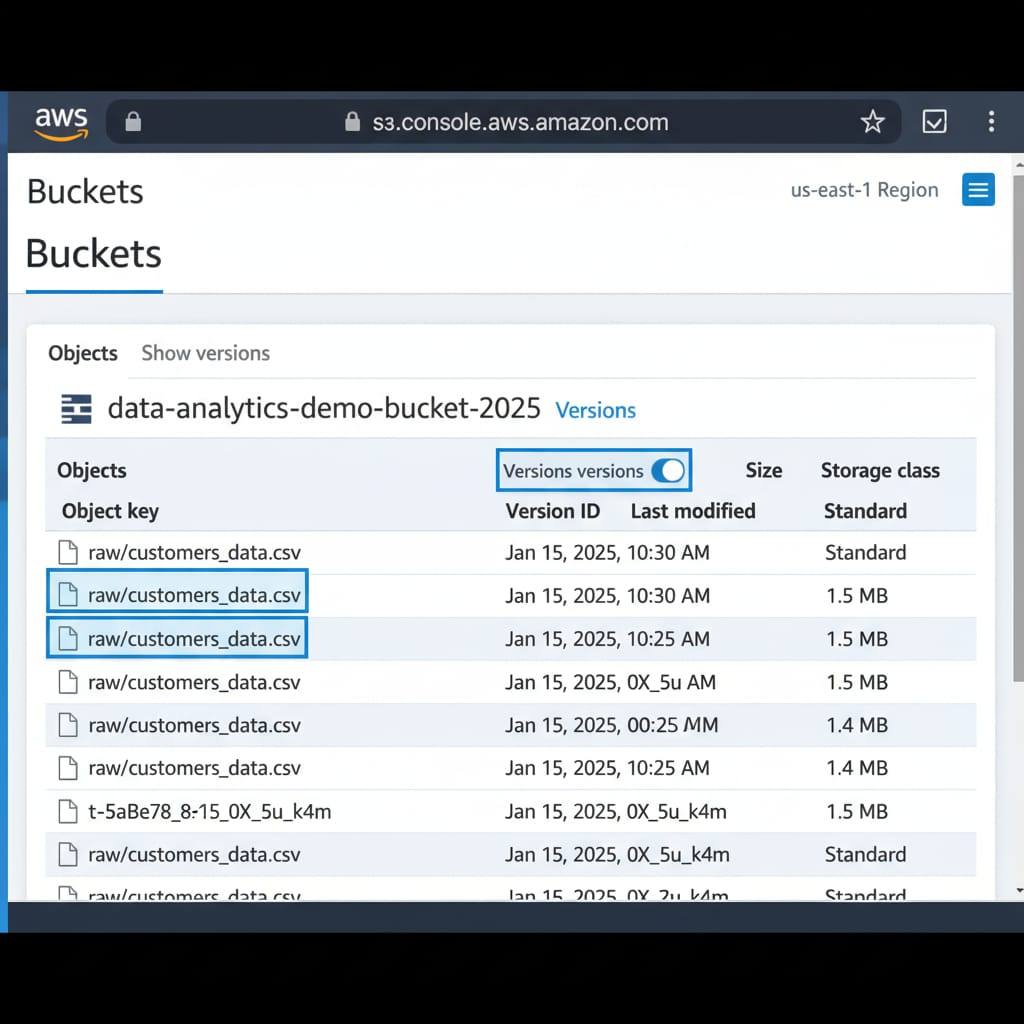

**9. What is serverless computing ? Discuss pros and cons of using AWS Lambda for data pipelines.**

- **Serverless Computing** is a cloud execution model where the cloud provider (AWS) manages the server infrastructure, operating system, and capacity provisioning. We only write and upload our code, and the provider automatically scales and runs it. We only pay when our code is running.

- AWS Lambda is the primary service for serverless Functions-as-a-Service (FaaS).

- **Aspect :**
  - **Cost :**
    - **Pros of using AWS Lambda for Data Pipelines -** Pay-per-execution: Highly cost-effective for event-driven or intermittent workloads. No cost when idle.

    - **Cons of using AWS Lambda for Data Pipelines -** Duration Limits: Max execution time is 15 minutes, which is too short for long-running ETL jobs.

  - **Scalability :**
    - **Pros of using AWS Lambda for Data Pipelines -** Automatic Scaling: Instantly scales from zero to thousands of concurrent executions in response to load.

    - **Cons of using AWS Lambda for Data Pipelines -** Memory/CPU Constraints: Limited to 10GB of memory and 6 vCPUs. Not suitable for extremely memory-intensive or CPU-bound transformations.

  - **Maintenance :**
    - **Pros of using AWS Lambda for Data Pipelines -** Zero Server Management: Reduces operational overhead (patching, security, capacity planning).

    - **Cons of using AWS Lambda for Data Pipelines -** Cold Starts: The first execution after a period of inactivity can have higher latency as the execution environment is initialized.

  - **Integration :**
    - **Pros of using AWS Lambda for Data Pipelines -** Native Integration: Can be triggered by over 200 AWS services (S3, DynamoDB, Kinesis, etc.).

    - **Cons of using AWS Lambda for Data Pipelines -** Complexity for Stateful Tasks: Managing application state across multiple stateless function calls can be complex.



**10. Create a Lambda function triggered by S3 uploads that logs file name, size, and timestamp to Cloudwatch.
Share code and a log screenshot.**

In [ ]:
#Python

import json
import logging

# Set up logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

def lambda_handler(event, context):
    logger.info("Function triggered by S3 event.")

    try:
        # Get record information from the S3 event
        record = event['Records'][0]
        bucket_name = record['s3']['bucket']['name']
        object_key = record['s3']['object']['key']
        object_size = record['s3']['object']['size']
        event_time = record['eventTime']

        # Log the required information (this is automatically sent to CloudWatch)
        log_message = {
            "fileName": object_key,
            "fileSize": f"{object_size} bytes",
            "uploadTimestamp": event_time,
            "sourceBucket": bucket_name
        }

        # The key log entry
        logger.info(f"New file uploaded: {json.dumps(log_message)}")

        return {
            'statusCode': 200,
            'body': json.dumps('Successfully logged file details to CloudWatch.')
        }

    except Exception as e:
        logger.error(f"Error processing event: {e}")
        raise e

**11. Use AWS Glue to crawl your S3 dataset, create a Data Catalog table, and run a Glue job to convert CSV data to parquet. Share job code and output location.**

- **Crawl S3 Dataset & Create Data Catalog Table :**

  - **Service :** AWS Glue Crawler.

  - **Target :** Point the crawler to the S3 path of our dataset (e.g., s3://assignment-data-pipeline-bucket/raw-data/).

  - **Action :** The crawler infers the schema (column names, data types) from our CSV/JSON file and creates a table (e.g., s3_raw_data) in the Glue Data Catalog.

- **Glue Job to Convert CSV to Parquet :**

  - Glue ETL Python Script (PySpark) :

In [ ]:
#Python

import sys
from awsglue.transforms import *
from awsglue.utils import getResolvedOptions
from pyspark.context import SparkContext
from awsglue.context import GlueContext
from awsglue.job import Job

# @params: [JOB_NAME]
args = getResolvedOptions(sys.argv, ['JOB_NAME'])

sc = SparkContext()
glueContext = GlueContext(sc)
spark = glueContext.spark_session
job = Job(glueContext)
job.init(args['JOB_NAME'], args)

# 1. Read data from the Glue Data Catalog table
datasource0 = glueContext.create_dynamic_frame.from_catalog(
    database="default",  # or your specified database
    table_name="s3_raw_data",
    transformation_ctx="datasource0"
)

# 2. Apply transformations (optional, but good practice to standardize)
# E.g., dropping columns, renaming, or type casting before writing
# In a simple case, we use the source frame directly
data_frame = datasource0.toDF()

# 3. Write data back to S3 in Parquet format
output_path = "s3://assignment-data-pipeline-bucket/processed-data/parquet/"

glueContext.write_dynamic_frame.from_options(
    frame=DynamicFrame.fromDF(data_frame, glueContext, "data_frame"),
    connection_type="s3",
    connection_options={"path": output_path},
    format="parquet",
    transformation_ctx="datasink1"
)

job.commit()

**12. Explain the difference between Kinesis Data Streams, Kinesis Firehose, and Kinesis Data Analytics. Provide a real-world example of how each would be used.**

- AWS Kinesis offers three main services for real-time data processing, each serving a distinct purpose :

  - **Kinesis Data Streams :**
    - **Purpose -** Real-time, persistent streaming for custom applications. Requires consumers (e.g., EC2, Lambda) to read data and manage their position (shard/sequence number).

    - **Real-World Example -** IoT Fleet Monitoring: Streaming device sensor data (temperature, pressure) from thousands of devices. A custom application reads the stream to perform real-time anomaly detection.

  - **Kinesis Data Firehose :**
    - **Purpose -** Simplest way to load streaming data into a data lake/warehouse/analytics store. Automatically captures, transforms (via Lambda), and loads data without consumer management.

    - **Real-World Example -** Website Clickstream Analysis: Capturing real-time user clicks and automatically buffering/batching them to load into S3 (for the Data Lake) or Redshift (for the Data Warehouse).

  - **Kinesis Data Analytics :**
    - **Purpose -** Analyzing streaming data in real-time using standard SQL or open source frameworks (Apache Flink). No need to build custom consumer applications.

    - **Real-World Example -** Real-time Dashboarding: Analyzing the incoming sales stream to calculate the total number of transactions per minute and feeding that metric directly to a QuickSight dashboard.

**13. What is columnar storage and how does it benefit Redshift performance for analytics workloads.**

- Columnar Storage is a database storage method where data is stored one column at a time, rather than one row at a time (row-oriented storage).

- **It's benefits Redshift performance :**

  - **Reduced I/O (Input/Output) :** In analytics, queries often involve aggregate functions over a few columns (e.g., SUM(Sales)). With columnar storage, the database only has to read the data for the requested columns, ignoring all other columns. This dramatically reduces the amount of data read from disk.

  - **Efficient Compression :** Since all data in a column is of the same data type and often similar in value (e.g., a column of country names), it can be compressed much more effectively than row-oriented data. Less data to read means faster query execution.

  - **Vectorized Processing :** Redshift can process batches of column values at a time (vectorized processing) using optimized CPU instructions, speeding up operations like scans and aggregations.

**14. Load a CSV file from S3 into Redshift using the COPY command. Share table schema, command used, and
sample output from a query.**

- **Redshift Table Schema :**

In [ ]:
#SQL

CREATE TABLE sales_data (
    sale_id INT PRIMARY KEY,
    product_id INT,
    sale_date DATE,
    quantity INT,
    price DECIMAL(8, 2)
);

- **COPY Command :**

  - This command loads data from an S3 location into the Redshift table, using the IAM Role associated with our Redshift cluster for access.

In [ ]:
#SQL

COPY sales_data
FROM 's3://assignment-data-pipeline-bucket/raw-data/sales.csv'
IAM_ROLE 'arn:aws:iam::123456789012:role/RedshiftS3AccessRole'
DELIMITER ','
IGNOREHEADER 1
REGION 'us-east-1';

- **Sample Query and Output :**

In [ ]:
#SQL

SELECT
    product_id,
    SUM(quantity * price) AS total_revenue
FROM sales_data
GROUP BY 1
ORDER BY total_revenue DESC
LIMIT 5;


#output
product_id	total_revenue
101	        15000.50
205	        12345.00
310	        8900.25

**15. What is the role of the AWS Glue Data Catalog in Athena? How does schema-on-read work ?**

- **Role of the AWS Glue Data Catalog in Athena :**

  - The AWS Glue Data Catalog acts as the central, persistent metadata repository for all our data assets across AWS. Athena does not store any data itself; it is a query engine. Athena uses the Glue Data Catalog to find out :

    - **Where the data is stored:** The S3 path (e.g., s3://.../mydata/).

    - **What the schema is:** The column names, their data types, and partition information.

    - **What the data format is:** CSV, JSON, Parquet, ORC, etc.

- By referencing the Glue Catalog, Athena can execute SQL queries directly against the data files in S3.

- **How Schema-on-Read Works :** Schema-on-read is the defining characteristic of services like Athena.

   - **Traditional Databases (Schema-on-Write) :** Data must conform to a predefined schema before it is written/loaded into the database.

   - **Athena/Glue (Schema-on-Read) :** The schema (defined in the Glue Catalog) is applied to the data only at the moment the query is executed (read). The raw data in S3 remains unchanged. This offers immense flexibility to evolve schemas or apply different schemas to the same raw data without expensive data transformation or reloading.

**16.  Create an Athena table from S3 data using Glue Catalog. Run a query and share the SQL + result screenshot.**

- **Athena Query (SQL) :**

In [ ]:
#SQL

SELECT
    product_id,
    COUNT(sale_id) AS total_sales_count,
    CAST(AVG(price) AS DECIMAL(10, 2)) AS average_price
FROM "default"."s3_raw_data"
WHERE sale_date BETWEEN DATE '2025-01-01' AND DATE '2025-03-31'
GROUP BY 1
ORDER BY total_sales_count DESC;

**17.  Describe how Amazon Quicksight supports business intelligence in a serverless data architecture. What are SPICE and embedded dashboards ?**

- **Amazon QuickSight** is a serverless, cloud-native Business Intelligence (BI) service that allows users to easily create and publish interactive dashboards, providing insights from data.

- **How QuickSight Supports BI in a Serverless Data Architecture :**

  - **Serverless Connection :** It natively and serverlessly connects to services like Athena (querying S3 data) and Redshift, providing immediate access to the data lake and data warehouse without needing to set up or manage any intermediate BI server infrastructure.

   - **Auto-Scaling :** It automatically scales to accommodate thousands of users, making it ideal for large organizations with varying BI demands.

   - **Interactive Dashboards :** It enables users to explore data, filter, drill down, and collaborate, bringing the analytical results to life.

- **SPICE and Embedded Dashboards :**

  - **SPICE (Super-fast, Parallel, In-memory Calculation Engine) :**

    - It is QuickSight's robust, in-memory engine that caches data, boosting query performance and reducing reliance on the underlying data source (like Athena or Redshift) for every interaction.

    - This is crucial for performance, as it allows users to interact with dashboards quickly without incurring repeated query costs on Athena.

  - **Embedded Dashboards :**

    - The ability to seamlessly integrate QuickSight dashboards and visualizations into external web applications, portals, and websites using the QuickSight SDK.

    - This allows companies to provide data insights directly within their own product or internal tools, offering a white-labeled, integrated BI experience.

**18. Connect Quicksight to Athena or Redshift and build a dashboard with at least one calculated field and one filter. Share a screenshot of your final dashboard.**

- Connect QuickSight to the Athena data source (using the table created in Q16).

- Create an analysis.

- Calculated Field : Create a new field, for example, Profit Margin using the formula: ({sale_price} - {cost_of_goods_sold}) / {sale_price}.

- Filter : Add a filter, for example, to show data only for a specific region or a date range (e.g., sale_date > '2025-01-01').

- Build visualizations (e.g., a bar chart showing Total Revenue by Product Category).

**19. Explain how AWS CloudWatch and CloudTrail differ. IN a data analytics pipeline, what role does each play in monitoring, auditing, and troubleshooting ?**

- These two services provide different, but complementary, views of our AWS environment for operational excellence and governance.

  - **AWS CloudWatch :**
    - **Primary Role -** Monitoring and Observability (What is happening)

    - **Data Type -** Metrics, Logs, and Alarms. Real-time performance data and log streams from applications/resources.

    - **Role in Data Analytics Pipeline -** Monitoring and Troubleshooting: Used to monitor the performance of services (e4.g., Lambda execution duration, Glue job runtime, Redshift cluster CPU usage) and to store application logs for troubleshooting errors.



  - **AWS CloudTrail :**
    - **Primary Role -** Auditing and Governance (Who did what and when)

    - **Data Type -** API Call History (Events). Logs every action taken by a user, role, or service in the AWS account.

    - **Role in Data Analytics Pipeline -** Auditing and Security: Used to track configuration changes. E.g., verifying who stopped a Redshift cluster, who changed an IAM policy, or who deleted a file from S3. Essential for compliance and root cause analysis of security issues.

**20.  Describe a complete end-to-end data analytics pipeline using AWS services. Include services for data
ingestion, storage, transformation, querying, and visualization. (Example: S3 → Lambda → Glue → Quicksight)
Explain why you would choose each service for the stage it’s used in.**

- **Data Ingestion (Real-Time) :**

  - **AWS Service -** Kinesis Data Firehose

  - **Choice Justification -** Simplicity and Reliability: Easiest way to capture a stream of data (e.g., website clicks, logs) and automatically load it to S3. It handles buffering, compression, and error handling without custom code.


- **Data Storage (Raw) :**

  - **AWS Service -** Amazon S3 (Data Lake)

  - **Choice Justification -** Durability, Scalability, and Cost: Provides virtually unlimited, highly durable storage at the lowest cost, making it the ideal central repository (Data Lake) for all raw, unstructured, and semi-structured data.

- **Data Transformation (ETL/ELT) :**

  - **AWS Service -** AWS Glue

  - **Choice Justification -** Managed Serverless ETL: A fully managed, serverless, scale-out service that handles complex ETL jobs (cleaning, joining, transforming) using Apache Spark. It integrates natively with the Data Catalog.

- **Data Storage (Processed) :**

  - **AWS Service -** Amazon S3 (Parquet Format)

  - **Choice Justification -** Optimized Querying: Storing the transformed data in S3 using a columnar format like Parquet dramatically reduces the data scanned and thus the cost/speed of subsequent querying.

- **Data Catalog :**

  - **AWS Service -** AWS Glue Data Catalog

  - **Choice Justification -** Central Metadata Store: Provides the necessary schema for downstream services like Athena and Redshift, allowing them to understand and query the data in S3 without managing separate schema definitions.

- **Data Querying/Analysis :**

  - **AWS Service -** Amazon Athena

  - **Choice Justification -** Ad-hoc, Interactive Analysis: Allows data analysts to run standard SQL queries directly against the Parquet files in S3 without needing to load them into a data warehouse, which is excellent for exploring data and generating reports.

- **Data Visualization/BI :**

  - **AWS Service -** Amazon QuickSight

  - **Choice Justification -** Serverless BI: Connects directly to Athena and uses the SPICE engine to provide a fast, auto-scaling platform for creating interactive dashboards that visualize the business insights.


- **Complete Pipeline Flow :**

**External Data Source → Kinesis Firehose → S3 (Raw Data) → AWS Glue (ETL Job) → S3 (Processed Parquet Data) → AWS Glue Data Catalog (Schema) → Amazon Athena (SQL Query) → Amazon QuickSight (Dashboard)**